In [7]:
#Author: Adrian J 2022-05
import pandas as pd
import matplotlib.pyplot as plt

from delta import * #to-do remove the wild import from delta
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [2]:
#get or create spark delta session
builder = (
    SparkSession
    .builder
    .master("local")
    .appName("p4_data_analysis")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [3]:
#read delta table
schema = 'uc_assignment'
table_name = 'uc_delta_session_events'
uc_path = f'/home/jovyan/work/data_lake/use_case/{schema}/{table_name}'
df_uc_assignment = spark.read.format("delta").load(uc_path)
df_uc_assignment.cache() 

DataFrame[country: string, player_id: string, session_id: string, start_ts: timestamp, end_ts: timestamp, session_status: int, DL_INSERT_TS: timestamp, DL_UPDATE_TS: timestamp, EVENT_DATE: date]

## Player Session Insights
The table used for the analysis is the table uc_delta_session_events is ACID transactions enabled table. This means each row is a unique session_id. 

Table description:\
-*country*: country\
-*player_id*: unique player uuid\
-*session_id*: unique session uuid\
-*start_ts*: start session timestamp\
-*end_ts*: end session timestamp\
-*session_status*: 0-> not completed, 1-> completed\
-*DL_INSERT_TS*: Data Lake Insert row ts\
-*DL_UPDATE_TS*: Data Lake update row ts

1. How many sessions are in the dataset?

In [15]:
number_of_sessions = df_uc_assignment.count()
print(f"Number of sessions in the dataset is : {number_of_sessions}")

Number of sessions in the dataset is : 500587


2. How many session are completed per country? top 10 results sorted by count and country

In [28]:
(df_uc_assignment
 .groupBy("country")
 .agg(F.sum("session_status").alias("completed_sessions_per_country"))
 .sort(F.col("completed_sessions_per_country").desc(), F.col("country").asc())
 .show(10)
)
#2839

+-------+------------------------------+
|country|completed_sessions_per_country|
+-------+------------------------------+
|     IT|                          2839|
|     SH|                          2672|
|     AZ|                          2670|
|     AT|                          2655|
|     WF|                          2616|
|     VA|                          2602|
|     HU|                          2584|
|     IL|                          2563|
|     RO|                          2550|
|     KR|                          2535|
+-------+------------------------------+
only showing top 10 rows



3. How many session are completed per player? top 10 results sorted by count and country

In [31]:
(df_uc_assignment
 .groupBy("player_id")
 .agg(F.sum("session_status").alias("completed_sessions_per_player"))
 .sort(F.col("completed_sessions_per_player").desc(), F.col("player_id").asc())
 .show(10, truncate=False)
)

+--------------------------------+-----------------------------+
|player_id                       |completed_sessions_per_player|
+--------------------------------+-----------------------------+
|0052e4cfaf494af29d567fcf93057029|50                           |
|008c31d6d87d4a72ade8900d4c031f59|50                           |
|019f6864a44e4cd1a271db0fc08c7555|50                           |
|01d1f31c3c864538a6a5f3cb238d0072|50                           |
|0259292bb77e4aaba6782372085990be|50                           |
|04318f09e6e7434bb48226f4a8745c21|50                           |
|060243602575481db3643bdaacc1146e|50                           |
|067b20022f2040b0a0b94efb221e1a6e|50                           |
|072d69b007434968966b4c9ddc4e987c|50                           |
|08037331842341b2bbfd51d2b12f9049|50                           |
+--------------------------------+-----------------------------+
only showing top 10 rows



4. What is the country with the most sessions started in 2016?

In [39]:
country_with_most_started_sessions_2016 =(
    df_uc_assignment
    .withColumn("session_year", F.year(F.col("start_ts")))
    .where(F.col("session_year")=="2016")
    .groupBy("country")
    .agg(F.count("session_status").alias("started_sessions_per_country"))
    .sort(F.col("started_sessions_per_country").desc(), F.col("country").asc())
    .select("country").collect()[0][0]
)
print(f"The country with most started sessions in 2016 was: {country_with_most_started_sessions_2016}")

The country with most started sessions in 2016 was: IT


5. player session completed per country plot sorted by count desc and countr asc

In [11]:
pd_completed_session_per_country = (
    df_uc_assignment
    .groupBy("country")
    .agg(F.sum("session_status").alias("completed_sessions_per_country"))
    .sort(F.col("completed_sessions_per_country").desc(), F.col("country").asc())
    .limit(10)
    .toPandas()
)

pd_completed_session_per_country

,country,completed_sessions_per_country
0,IT,2839
1,SH,2672
2,AZ,2670
3,AT,2655
4,WF,2616
5,VA,2602
6,HU,2584
7,IL,2563
8,RO,2550
9,KR,2535


<AxesSubplot:xlabel='country'>

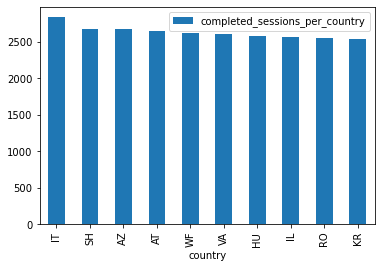

In [21]:
pd_completed_session_per_country.plot.bar(x='country', y='completed_sessions_per_country')